In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

from train import Trainer
from dataset import get_train_test_splits, make_datasets

font = {'family' : 'arial',
        'size'   : 8}
matplotlib.rc('font', **font)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams.update({'font.size': 8})

In [2]:
colors = sns.color_palette("Paired")
keys = [5,6,7,9,0,1,2,3]

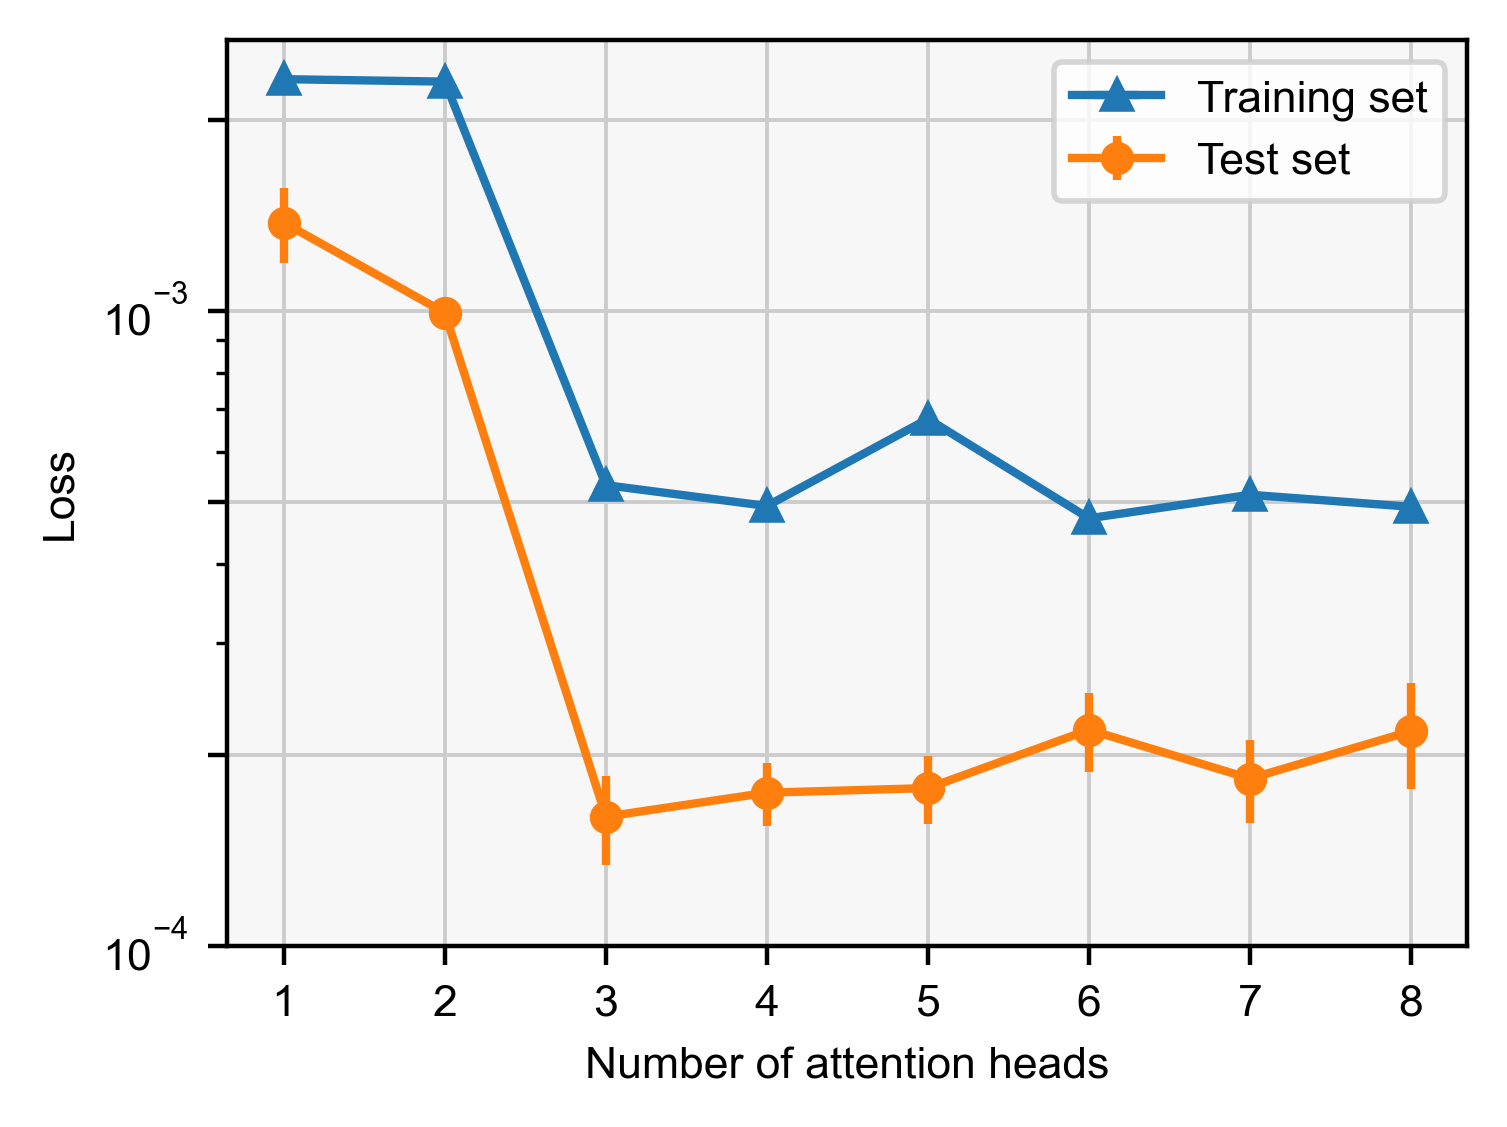

In [61]:
train_loss = []
val_loss = []
for i in range(1, 9):
    model_file = f"test_sites/results_{i}.pt"
    trainer = torch.load(model_file)
    train_loss.append(trainer.train_loss_history)
    val_loss.append(trainer.val_loss_history)
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)
fig, ax = plt.subplots(figsize=(4, 3), dpi=400)
ax.errorbar(np.arange(1, 9), train_loss[:, 200:].mean(1), xerr=train_loss[:, 200:].std(1), marker='^', markersize=5)
ax.errorbar(np.arange(1, 9), val_loss[:, 200:].mean(1), yerr=val_loss[:, 200:].std(1), marker='o', markersize=5)
ax.legend(["Training set", "Test set"])
ax.set_facecolor((0.97, 0.97, 0.97))
ax.grid(color="0.8", linestyle='-', linewidth=0.7, zorder=-10)
ax.set_xlabel("Number of attention heads")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_yticks([1e-4, 2e-4, 5e-4, 1e-3, 2e-3])
ax.set_xticks(np.arange(1, 9))
plt.savefig("figures/sorbnetx-sites.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [38]:
def evaluate_model(model_path, data_paths):
    trainer = torch.load(model_path)
    trainer.model = trainer.model.to("cpu")

    df_train, df_test, n_comp = get_train_test_splits(
        data_paths,
        trainer.hp["train_components"],
        trainer.hp["test_components"],
    )
    data_train, data_test, norms = make_datasets(df_train, df_test, n_comp, return_norm=True)
    x_train, y_train = data_train.tensors
    x_test, y_test = data_test.tensors

    molecules = ['pX', 'oX', 'mX', 'bz', 'tol', 'eb', 'H2', 'eth']
    with torch.no_grad():
        y_train_pred, _, _ = trainer.model(x_train)
        y_test_pred, _, _ = trainer.model(x_test)
        y_train_pred[torch.isnan(y_train_pred)] = 0
        y_test_pred[torch.isnan(y_test_pred)] = 0
        
    return torch.cat([y_train, y_train_pred], 1).numpy(), torch.cat([y_test, y_test_pred], 1).numpy(), norms, trainer.model
    
    
paths = ["data-full/MFI-0.csv", "data-binary-ternary/MFI-0.csv"] 

results_sorbnetx = evaluate_model("test_sites/results_3.pt", paths)
results_mlp = evaluate_model("models/mlp.pt", paths)
norms = results_sorbnetx[2]
results = results_sorbnetx[:2] + results_mlp[:2]

In [36]:
files = ["transformer-train.txt", "transformer-test.txt", "mlp-train.txt", "mlp-test.txt"]
names = ['p-xylene', 'o-xylene', 'm-xylene', 'benzene', 'toluene', 'ethylbenzene', 'hydrogen', 'ethane']
# (ben, tol, eb, oX, mX, pX, eth, hyd)
permutation = [3, 4, 5, 1, 2, 0, 7, 6]

sizes = 1 * norms ** 0.3
print(sizes)

[2.03431921 0.64952916 2.93180879 2.73499431 2.82970929 2.63737216
 5.20272429 2.98729149]


In [18]:
titles = ["SorbNetX, training",
          "SorbNetX, test",
          "MLP baseline, training",
          "MLP baseline, test",
         ]

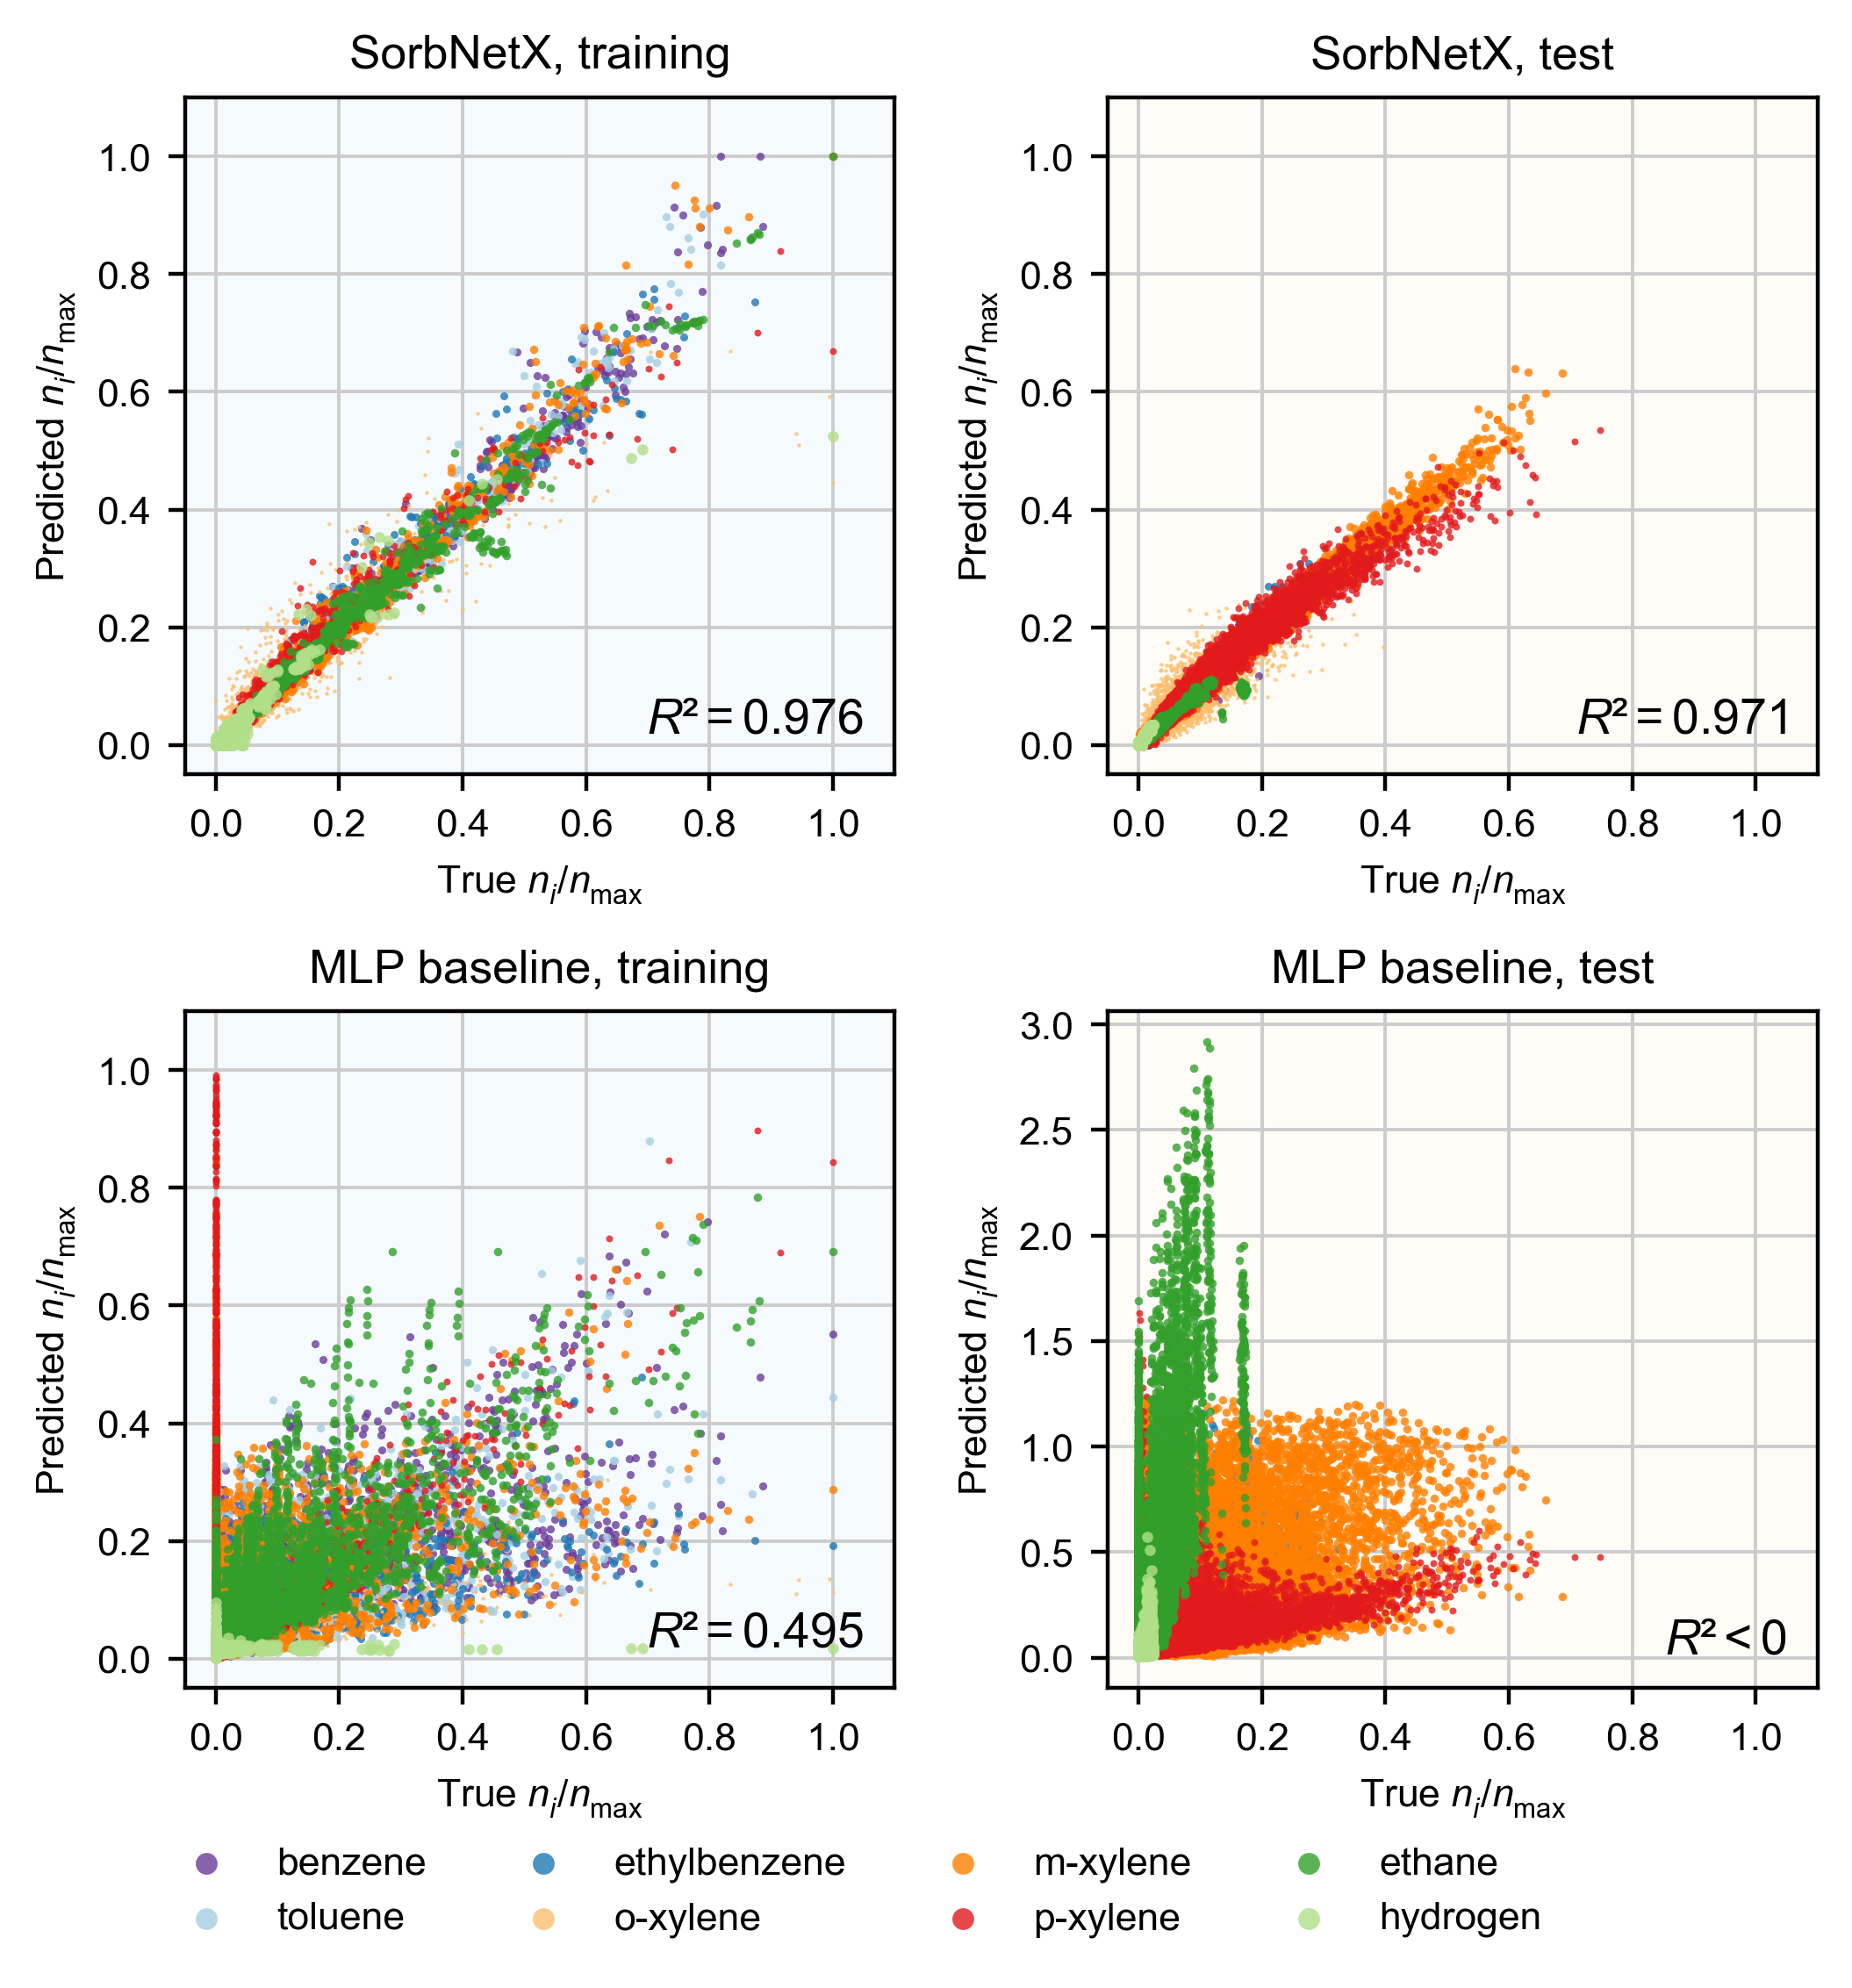

In [30]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(6, 6)
fig.set_dpi(400)
plt.subplots_adjust(wspace=0.3, hspace=0.35)

ncomp = 8
for i, ax in enumerate(axes.ravel()):
    data_cur = results[i]
    ax.set_title(titles[i])
    if i % 2 == 0:
        ax.set_facecolor((0.96, 0.98, 1))
    else:
        ax.set_facecolor((1, 0.99, 0.97))
    ax.grid(color="0.8", linestyle='-', linewidth=0.7, zorder=-10)
    for j in permutation:  
        ax.scatter(data_cur[:, j], data_cur[:, j + ncomp], 
                   color=colors[keys[j]], s=sizes[j], alpha=0.8, linewidth=0, zorder=10)#, linewidth=0.05 * sizes[j], edgecolor='1', alpha=1)
        ax.set_xlim([-0.05, 1.1])
    if i < 3:
        ax.set_ylim([-0.05, 1.1])
    ax.set_xlabel("True $n_i/n_\mathrm{max}$")
    ax.set_ylabel("Predicted $n_i/n_\mathrm{max}$")
    data_ravel = np.vstack([data_cur[:, :ncomp].ravel(), data_cur[:, ncomp:].ravel()]).T
    data_ravel = data_ravel[data_ravel[:, 0] != 0, :] # remove non-existent components
    r2 = 1 - np.sum((data_ravel[:, 0] - data_ravel[:, 1]) ** 2) / np.sum((data_ravel[:, 0] - np.mean(data_ravel[:, 0])) ** 2)
    ax.text(1.05, 0.02, "$R²=%.3f$" % r2 if r2 > 0 else "$R²<0$", fontsize=10, ha="right")
    #print(r2_score(data_cur[:, :ncomp], data_cur[:, ncomp:]))
legend = fig.legend(np.array(names)[permutation], frameon=False, 
           loc='lower left', bbox_to_anchor=(0.1, -0.01), ncol=4)
for handle in legend.legendHandles:
    handle.set_sizes([20])
plt.savefig('figures/sorbnetx-results.pdf', format='pdf', bbox_inches='tight')
plt.show()

(3, 8, 8)


torch.Size([24, 1, 8])


<ipython-input-60-13d703072c01>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(["a", "b"])


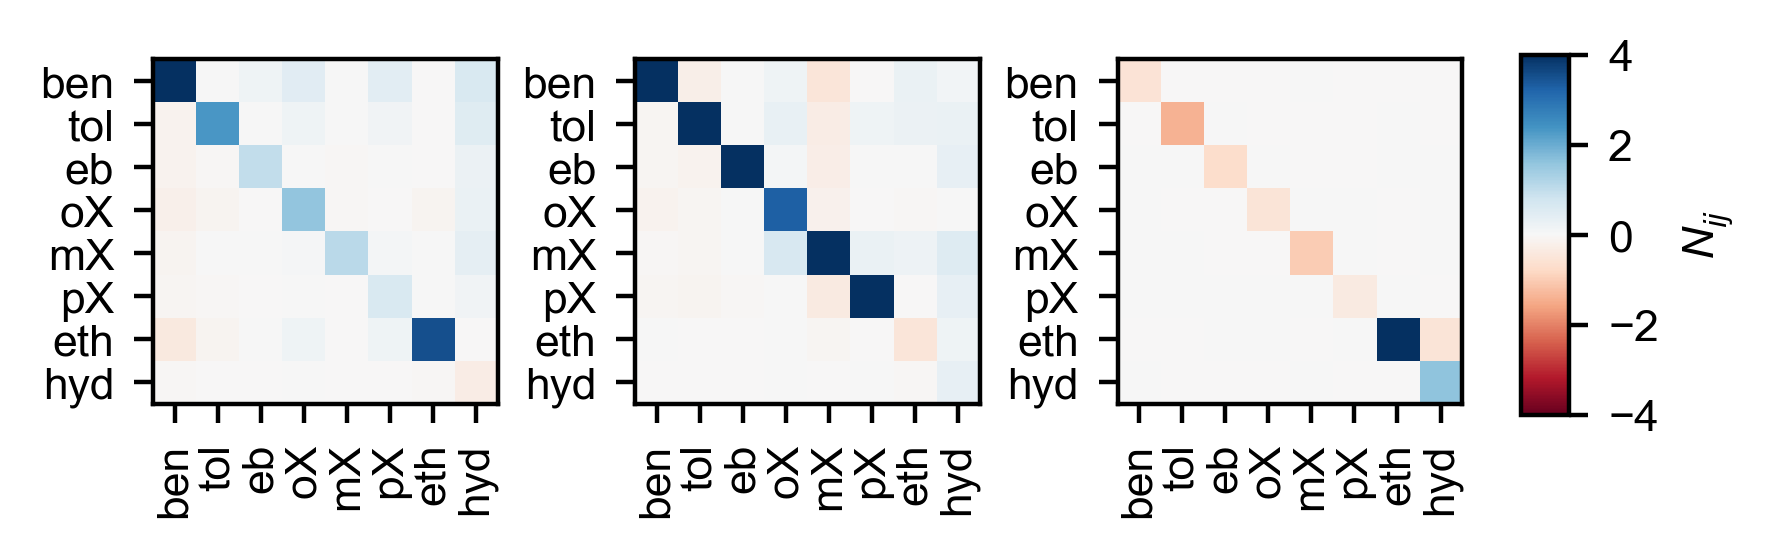

In [60]:
from sklearn.decomposition import PCA

labels = np.array(['pX', 'oX', 'mX', 'ben', 'tol', 'eb', 'hyd', 'eth'])
fig = plt.figure(figsize=(12, 3), dpi=400)
norm = matplotlib.colors.Normalize(vmin=-4.,vmax=4.)
plt.subplots_adjust(wspace=0.4)

model = results_sorbnetx[3]
w,  = list(model.attn.attnblock.layer_v.parameters())
print(w.shape)
w = w.view(model.n_site, ncomp, ncomp).detach().cpu().numpy()
pca = PCA(model.n_site)


for i in range(w.shape[0]):
    plt.subplot(181+i)
    mat = w[i, permutation][:, permutation]
    im = plt.imshow(mat, norm=norm, cmap='RdBu')#+ np.eye(8)
    plt.xticks(np.arange(8), labels[permutation], rotation='vertical')
    plt.yticks(np.arange(8), labels[permutation])
cbar_ax = fig.add_axes([0.41, 0.35, 0.01, 0.3])
cbar_ax.set_yticklabels(["a", "b"])
fig.colorbar(im, cax=cbar_ax, label='$N_{ij}$')
plt.savefig('figures/sorbnetx-analysis.pdf', format='pdf', bbox_inches='tight')
plt.show()